In [25]:
import pandas as pd
# load data
df = pd.read_csv("../combined_logs.csv")

df['referer'].head()
df = df[df['referer'] != '-']

In [26]:
unique_values = df['referer'].unique()

for value in unique_values:
    print(value)

https://www.google.com/
https://www.sitgesanytime.com/es/actualidad/agenda.htm
https://www.sitgesanytime.com/es/pl330/actualidad/agenda/id932/visita-palau-de-maricel-16.htm
https://www.sitgesanytime.com/es/pl330/actualidad/agenda/id1056/els-pastorets-2.htm
http://ip72.ip-91-134-184.eu/ca/pl30/planifica-el-teu-viatge/mapa-de-serveis/id584/albert-cabezas.htm
https://www.bing.com/
https://www.sitgesanytime.com/en/pl409/blog/id65/sitges-patchwork-festival.htm
https://www.sitgesanytime.com/plantilles/turisme/css/estils-base.css?v=23
https://www.sitgesanytime.com/es/actualidad.htm
https://www.google.es/
https://flo.uri.sh/
http://www.sitgestur.cat/include/ckeditor/plugins/smiley/images/angel_smile.gif
http://www.sitgestur.cat/plus/ad_js.php
http://www.sitgestur.cat/plus/flink_add.php
https://www.sitgesanytime.com/ca/
https://www.sitgesanytime.com/ca/lnk16/contacte.htm
https://www.sitgesanytime.com/ca/pl355/explora/festes-d-interes/id3/carnaval-de-sitges.htm
https://www.sitgesanytime.com/ca/p

In [27]:
import nltk
import re
import sqlite3
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from string import punctuation
from keras.preprocessing import text
from urllib.parse import unquote
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from gensim.models import Word2Vec
import multiprocessing
physical_devices = tf.config.list_physical_devices('GPU')
# physical_devices

# "../example.csv"

In [28]:
def preprocess_referer(ref):
    ref = re.sub(r'[/.-:]', ' ', ref)
    tokens = word_tokenize(ref)
    return tokens

# load data
conn = sqlite3.connect('data_ref.db')
df.to_sql('data_ref', conn, index=False, if_exists='replace')

# tokenize referers and create corpus
corpus_path = "corpus"
ref_tokens = []

chunk_size = 10000
for chunk in pd.read_sql_query('SELECT referer FROM data_ref', conn, chunksize=chunk_size):
    refs = chunk['referer']
    for ref in refs:
        decoded_ref = unquote(ref)
        tokens = preprocess_referer(decoded_ref)
        ref_tokens.append(tokens)

conn.close()

# save corpus to file
corpus_raw = '\n'.join([' '.join(tokens) for tokens in ref_tokens])
with open(corpus_path + "/referer_corpus_preprocessed.txt", "w", encoding="utf-8") as f:
    f.write(corpus_raw)

print("Corpus created successfully.")

Corpus created successfully.


In [29]:
print(ref_tokens[:3])

[['https', 'www', 'google', 'com'], ['https', 'www', 'sitgesanytime', 'com', 'es', 'actualidad', 'agenda', 'htm'], ['https', 'www', 'sitgesanytime', 'com', 'es', 'actualidad', 'agenda', 'htm']]


In [30]:
EMB_DIM = 300

w2v = Word2Vec(sentences=ref_tokens, vector_size=EMB_DIM, window=5, min_count=5, negative=15,
               epochs=10, workers=multiprocessing.cpu_count())

In [32]:
word_vectors = w2v.wv
result = word_vectors.similar_by_word("smiley")
print("Most similar to 'smiley':\n", result[:3])

result = word_vectors.similar_by_word("erleben")
print("Most similar to 'erleben':\n", result[:3])


Most similar to 'smiley':
 [('angel_smile', 0.9509021639823914), ('ckeditor', 0.9452711343765259), ('gif', 0.9444688558578491)]
Most similar to 'erleben':
 [('entdecken', 0.5871458649635315), ('aktuelles', 0.46081680059432983), ('sitges-auf-einen-blick', 0.43382346630096436)]


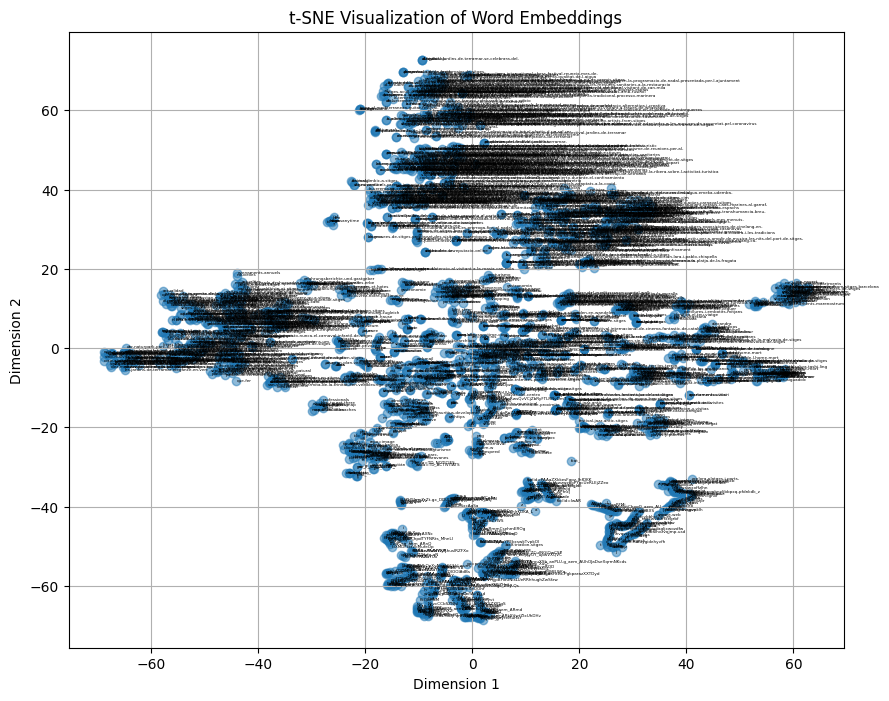

In [33]:
# get the vocabulary
vocab = list(word_vectors.key_to_index.keys())

# get the word vectors
word_vecs = [word_vectors[word] for word in vocab]

# convert word_vecs to a numpy array
word_vecs_np = np.array(word_vecs)

# use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
word_vecs_2d = tsne.fit_transform(word_vecs_np)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], alpha=0.5)

# annotate points with words
for word, (x, y) in zip(vocab, word_vecs_2d):
    plt.annotate(word, (x, y), size=3)

plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()